In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

from keras.models import Model, Sequential
from keras.layers import Dense, Input
from keras.layers import Dropout
from keras.layers import BatchNormalization, Reshape, Conv2DTranspose, Conv2D, Flatten
from keras.layers import LeakyReLU
from keras.optimizers import Adam
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

In [2]:
Z_DIM = 100
BATCH_SIZE = 256
BATCHES = 10000

In [3]:
(train_x, _), (_, _) = mnist.load_data()
train_x = train_x.reshape(train_x.shape[0], 28, 28, 1).astype("float32")
train_x = (train_x - 127.5) / 127.5

In [4]:
def create_generator():
    generator = Sequential()
    generator.add(Dense(units=256*7*7, input_dim=Z_DIM, use_bias=False))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU())
    generator.add(Reshape((7, 7, 256)))
    generator.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding="same", use_bias=False))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU())
    generator.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding="same", use_bias=False))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU())
    generator.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding="same", use_bias=False, activation="tanh"))
    generator.compile()
    
    return generator


g = create_generator()
g.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

In [5]:
def create_discriminator():
    discriminator = Sequential()
    discriminator.add(Conv2D(64, (5, 5), strides=(2, 2), padding="same", input_shape=[28, 28, 1]))
    discriminator.add(LeakyReLU())
    discriminator.add(Dropout(0.3))
    discriminator.add(Conv2D(128, (5, 5), strides=(2, 2), padding="same"))
    discriminator.add(LeakyReLU())
    discriminator.add(Dropout(0.3))
    discriminator.add(Flatten())
    discriminator.add(Dense(1, activation="sigmoid"))
    discriminator.compile(
        loss="binary_crossentropy", optimizer=Adam(learning_rate=0.0002, beta_1=0.5)
    )
    return discriminator


d = create_discriminator()
d.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [6]:
def create_gan(discriminator, generator):
    discriminator.trainable = False
    gan_input = Input(shape=(Z_DIM,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss="binary_crossentropy", optimizer="adam")
    return gan


gan = create_gan(d, g)
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 28, 28, 1)         2330944   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 2,543,809
Trainable params: 2,305,472
Non-trainable params: 238,337
_________________________________________________________________


In [7]:
def plot_generated_images(generator):
    # noise = np.random.normal(loc=0, scale=1, size=[10, Z_DIM])
    noise = np.random.uniform(-1, 1, size=(10, Z_DIM))
    generated_images = generator.predict(noise, verbose=0)
    generated_images = generated_images.reshape(10, 28, 28)
    plt.figure(figsize=(10, 1))
    for i in range(generated_images.shape[0]):
        plt.subplot(1, 10, i + 1)
        plt.imshow(generated_images[i], interpolation="nearest")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

2023-08-12 22:16:50.081832: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-08-12 22:16:51.492848: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Batch 1


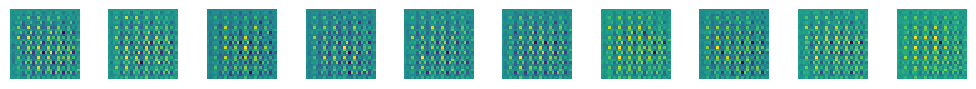

Batch 500


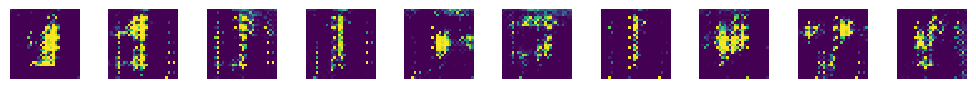

Batch 1000


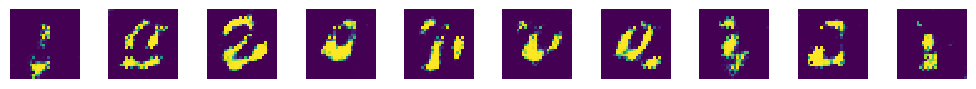

Batch 1500


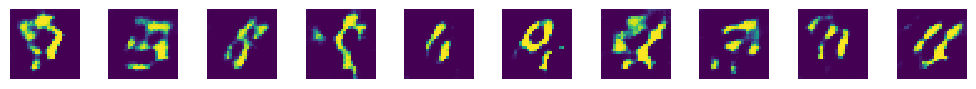

Batch 2000


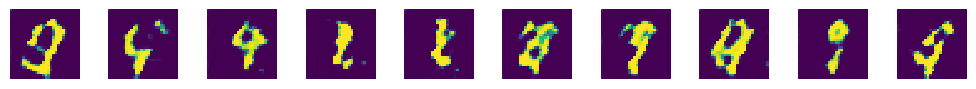

Batch 2500


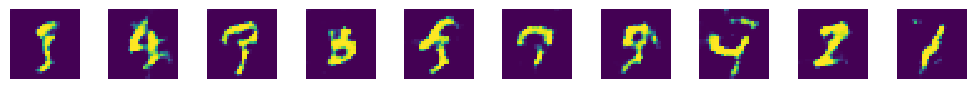

Batch 3000


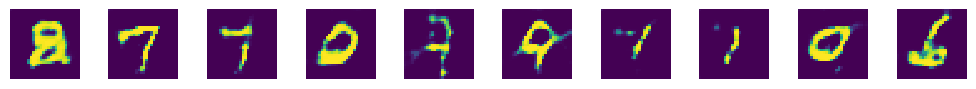

Batch 3500


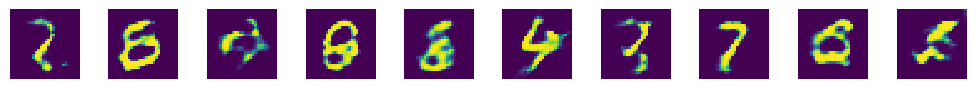

Batch 4000


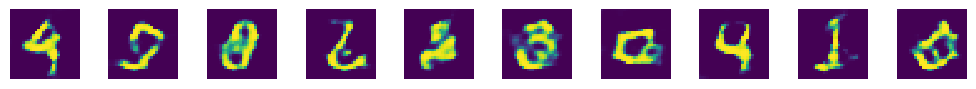

Batch 4500


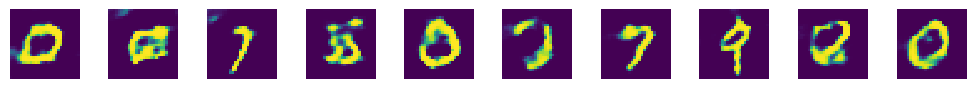

Batch 5000


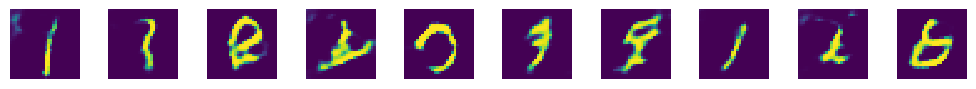

Batch 5500


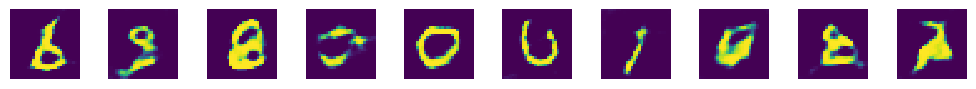

Batch 6000


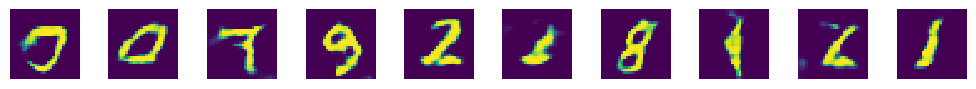

Batch 6500


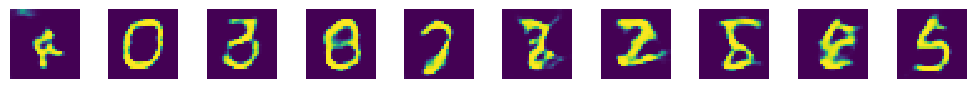

Batch 7000


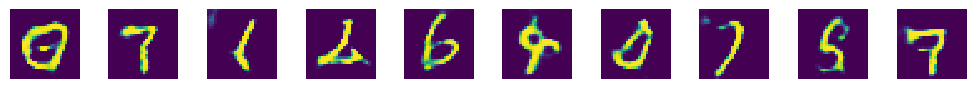

Batch 7500


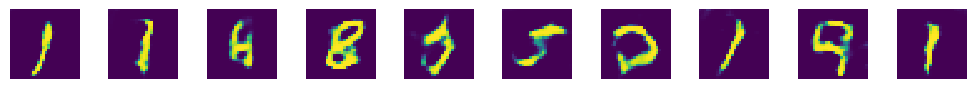

Batch 8000


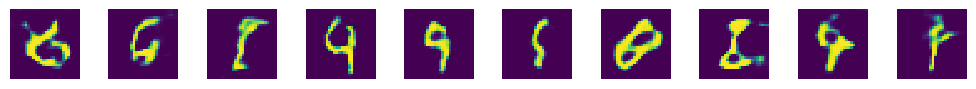

Batch 8500


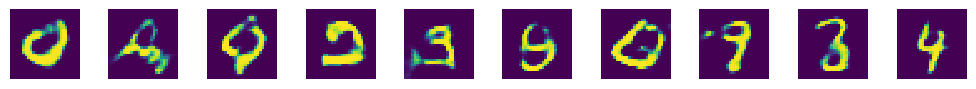

Batch 9000


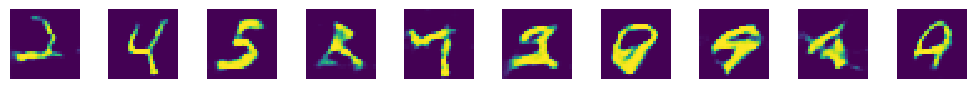

Batch 9500


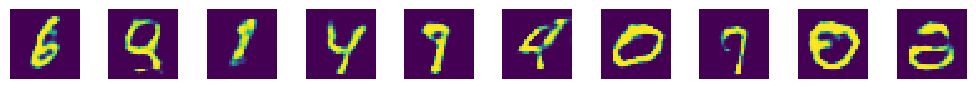

Batch 10000


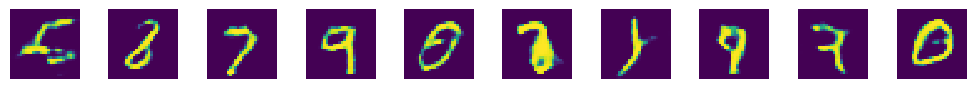

In [8]:
for b in range(BATCHES):
    # noise = np.random.normal(0, 1, [BATCH_SIZE, Z_DIM])
    noise = np.random.uniform(-1, 1, size=(BATCH_SIZE, Z_DIM))
    generated_images = g.predict(noise, verbose=0)
    image_batch = train_x[
        np.random.randint(low=0, high=train_x.shape[0], size=BATCH_SIZE)
    ]
    X = np.concatenate([image_batch, generated_images])
    y_dis = np.zeros(2 * BATCH_SIZE)
    y_dis[:BATCH_SIZE] = 1

    d.trainable = True

    d.train_on_batch(X, y_dis)

    # noise = np.random.normal(0, 1, [BATCH_SIZE, Z_DIM])
    noise = np.random.uniform(-1, 1, size=(BATCH_SIZE, Z_DIM))
    y_gen = np.ones(BATCH_SIZE)
    d.trainable = False
    gan.train_on_batch(noise, y_gen)

    if b == 0 or b % 500 == 499 or b == BATCHES - 1:
        print(f"Batch {b+1}/{BATCHES}")
        plot_generated_images(g)

In [9]:
g.save("generator.h5")
d.save("discriminator.h5")